---
### <b> Seleção para Bolsa de Inovação Tecnológica - Estudo do Uso da Força pela Polícia de Seattle </b> 

Este notebook é resultado do estudo que será avaliado pelo Programa Cientista Chefe no âmbito de seleção para a Bolsa de Inovação Tecnológica no Grupo de Redes de Computadores Engenharia de Software e Sistemas (GREat) da Universidade Federal do Ceará. Os dados são de ocorrências de uso da força pelas autoridades policiais de Seattle, os quais são públicos e [disponibilizados](https://www.seattle.gov/police/information-and-data/use-of-force-data/use-of-force-dataset) pelo site do governo da cidade.

<b>Links:</b>

[Dataset](https://drive.google.com/file/d/1XEZI0_L62hX8GFklbh-IIUdKHmGrjo0H/view)

[Governo de Seattle](https://www.seattle.gov/)
<br>
<br>
<b>Autor:</b>
<br>
**Pedro Jorge Chaves Mourão**
<br>
Graduado em Ciências Sociais - Universidade Estadual do Ceará (UECE)
<br>
Graduado em Análise e Desenvolvimento de Sistemas - Estácio
<br>
Mestrado  em Ciências Sociais - Universidade Federal do Ceará (UFC)
<br>
Doutorado em Sociolgia - Universidade Estadual do Ceará (UECE)
<br>
pjmourao_cs@hotmail.com| [Linkedin](https://www.linkedin.com/in/pedro-mour%C3%A3o/) | [Github](https://github.com/PJmouraocs)
<br>
<br>
<i>Fortaleza, 17 de abril de 2023</i>

---
<br>

# **Pré-processamento geral**

Importar bibliotecas e dados do dataframe

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


%matplotlib inline

In [ ]:
# Endereço do Dataset
url = 'https://drive.google.com/file/d/1XEZI0_L62hX8GFklbh-IIUdKHmGrjo0H/view'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head(5)


,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14264 entries, 0 to 14263
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 14264 non-null  object
 1   Incident_Num       14264 non-null  int64 
 2   Incident_Type      14264 non-null  object
 3   Occured_date_time  14264 non-null  object
 4   Precinct           14264 non-null  object
 5   Sector             13313 non-null  object
 6   Beat               14264 non-null  object
 7   Officer_ID         14264 non-null  int64 
 8   Subject_ID         14264 non-null  int64 
 9   Subject_Race       14264 non-null  object
 10  Subject_Gender     14264 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.2+ MB


# **Dicionário de Variáveis:**

ID: Chave composta para a identificação do uso da força

Incident_Num: Chave que identifica um incidente de força

Incident_Type: Classificação do nível de força

Occured_date_time: Data e horário do uso da força

Precinct: Delegacia onde houve o uso da força

Sector: Setor onde ocorreu o uso da força

Beat: Beat onde ocorreu o uso da força

Officer_ID: Chave de identificação do policial

Subject_ID: Chave de identificação do civil

Subject_Race: Etnia do civil

Subject_Gender: Gênero do civil

<Figure size 1500x1000 with 0 Axes>

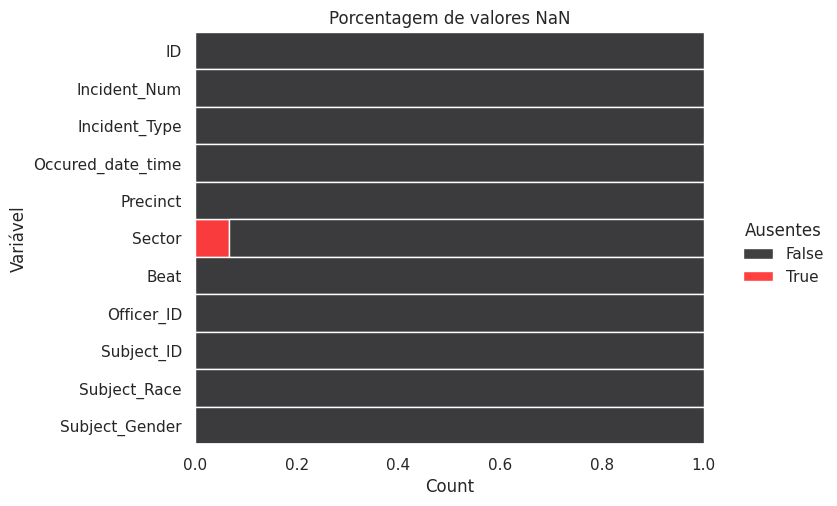

In [ ]:
# Verificar a presença de valores nulos e ambíguos:
sns.set_theme(style="dark")

# Definir a paleta de cores
custom_palette = sns.color_palette(["black", "red"])

# Plot da porcentagem dos valores NaN
plt.figure(figsize=(15,10))
sns.displot(
    data=df.isna().melt(var_name="Variável", value_name="Ausentes"),
    y="Variável",
    hue="Ausentes",
    multiple="fill",
    palette=custom_palette,
    aspect=1.5
)
plt.title('Porcentagem de valores NaN')
plt.show()


In [ ]:
qtde_faltantes_sector = df['Sector'].isna().sum()
porcentagem_faltantes_sector = df['Sector'].isna().sum()/len(df)*100

print('Temos {} valores com setores faltantes no dataset, que correspondem a {:.2f}% do total de dados.'.format(qtde_faltantes_sector,
round(porcentagem_faltantes_sector, 2)))

Temos 951 valores com setores faltantes no dataset, que correspondem a 6.67% do total de dados.


A função que examine os valores únicos presentes em cada coluna para identificar dados errados ou ambíguo que podem agir como valores ausentes não detectados.

In [ ]:
def locateAbsent(df):
    # Seleciona as colunas com valores numéricos e categóricos
    df_columns_int = df.select_dtypes(include='number')
    df_columns_str = df.select_dtypes(include='object')
    
    # Imprime os valores máximos e mínimos das colunas numéricas
    for coluna in df_columns_int.columns:
        val_max = df[coluna].max()
        val_min = df[coluna].min()
        print(f'Coluna: {coluna} | Valor máximo: {val_max} | Valor mínimo: {val_min}')
    
    # Imprime os valores únicos das colunas categóricas
    for coluna in df_columns_str.columns:
        val_unq = df[coluna].unique()
        print(f'\nColuna: {coluna} | Valores únicos: {val_unq}\n')
        
locateAbsent(df)


Coluna: Incident_Num | Valor máximo: 68122 | Valor mínimo: 178
Coluna: Officer_ID | Valor máximo: 6046 | Valor mínimo: 7
Coluna: Subject_ID | Valor máximo: 29302 | Valor mínimo: 4

Coluna: ID | Valores únicos: ['2014UOF-0001-1377-203' '2014UOF-0002-1098-166' '2014UOF-0003-1031-125'
 ... '2022UOF-0387-2614-15793' '2022UOF-0388-2670-15793'
 '2022UOF-0389-2739-8294']


Coluna: Incident_Type | Valores únicos: ['Level 1 - Use of Force' 'Level 2 - Use of Force'
 'Level 3 - Use of Force' 'Level 3 - OIS']


Coluna: Occured_date_time | Valores únicos: ['06/07/2014 12:09:00 AM' '05/30/2014 02:06:00 PM'
 '05/23/2014 05:24:00 PM' ... '05/24/2022 08:51:00 PM'
 '05/24/2022 08:52:00 PM' '04/19/2022 09:02:00 PM']


Coluna: Precinct | Valores únicos: ['East' 'West' 'South' 'North' 'Southwest' 'X' '-' '0' 'OOJ']


Coluna: Sector | Valores únicos: ['CHARLIE' 'GEORGE' 'KING' 'EDWARD' 'ROBERT' 'SAM' 'LINCOLN' 'UNION'
 'DAVID' 'FRANK' 'JOHN' 'NORA' nan 'BOY' 'OCEAN' 'QUEEN' 'WILLIAM' 'MARY']


Coluna: Beat 

Pode-se observar que há valores ausentes não representados por '-', '0', 'OOJ' nas colunas Precinct, Beat, Subject_Gender. E a culuna sector tem um nan.
Será necessário normalização através da substituição de variáveis categóricas, pois há os termos, 'm' que é deveria ser 'male'e "Unknown','Other' e '-' que suponho ser para definir Transgender.

###Substituindo valores p/ NaN###

In [ ]:
#Normalizando coluna Precinct 'X' '-' '0' 'OOJ'
df['Precinct'].replace(['OOJ', 'X', '0', '-'], np.nan, inplace=True)

#Normalizando coluna Beat
df['Beat'].replace(['XX', '99', '-', '0'], np.nan, inplace=True)

#Normalizando coluna Subject_Gender
df['Subject_Gender'].replace({'m': 'Male', 'Unknown': np.nan, '-': np.nan}, inplace=True)

##VISUALIZANDO SE OS DADOS FORAM NORMALIZADOS PARA NAN##

<Figure size 1500x1000 with 0 Axes>

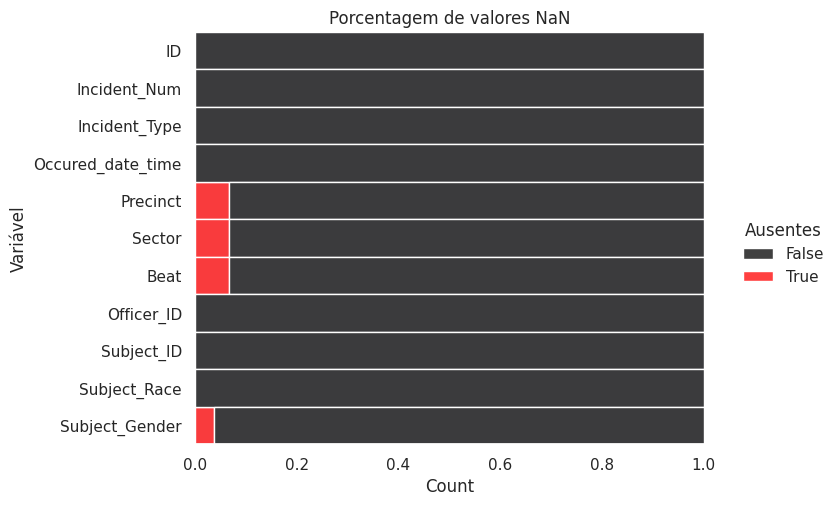

In [ ]:
# Verificar a presença de valores nulos e ambíguos:
sns.set_theme(style="dark")

# Definir a paleta de cores
custom_palette = sns.color_palette(["black", "red"])

# Plot da porcentagem dos valores NaN
plt.figure(figsize=(15,10))
sns.displot(
    data=df.isna().melt(var_name="Variável", value_name="Ausentes"),
    y="Variável",
    hue="Ausentes",
    multiple="fill",
    palette=custom_palette,
    aspect=1.5
)
plt.title('Porcentagem de valores NaN')
plt.show()

In [ ]:
# percentual de dados faltantes por coluna
pct_ausentes = round(df.isnull().sum() / len(df) * 100, 2)
print(pct_ausentes)

ID                   0.00
Incident_Num         0.00
Incident_Type        0.00
Occured_date_time    0.00
Precinct             6.67
Sector               6.67
Beat                 6.67
Officer_ID           0.00
Subject_ID           0.00
Subject_Race         0.00
Subject_Gender       3.72
dtype: float64


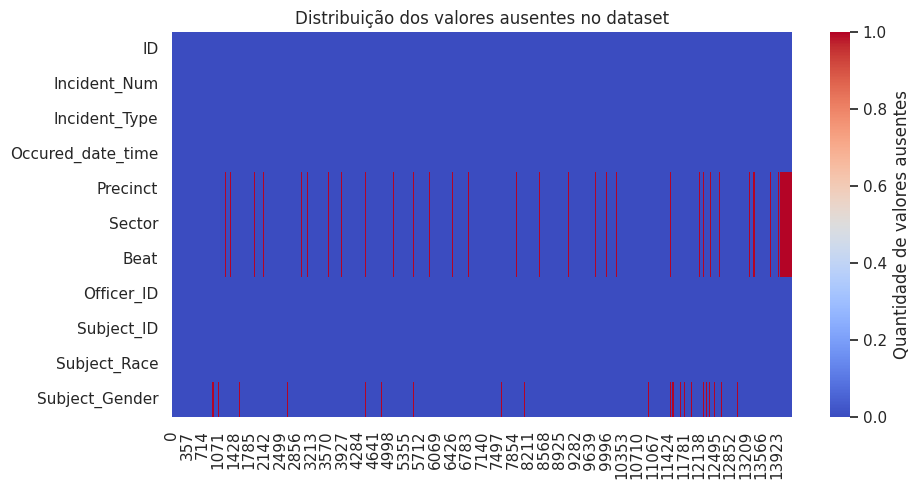

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Distribuição dos valores ausentes no dataset')
sns.heatmap(df.isna().transpose(),
cmap='coolwarm',
cbar_kws={'label':'Quantidade de valores ausentes'})
plt.show()

#**Faltam 6.67% dos dados das colunas Precinct, Sector e Beat.**
#**Faltam 3.72% dos dados da coluna Subject_Gender**

Faltam informações dos dados quanto ao local de ocorrência e gẽnero. É possivel analisar que não há dados da Beats p/preencher as seções que faltam e os dados da delegacia(Precinct). 

# **Tentando normalizar o dataframe**

É necessário lidar com os valores ausentes antes de aplicar técnicas de aprendizagem de máquina, já que muitos algoritmos de aprendizado de máquina não conseguem lidar com dados faltantes. Existem diversas abordagens para lidar com valores ausentes, como remoção das linhas com valores ausentes, preenchimento com a média, mediana ou moda, ou ainda preenchimento com algoritmos mais sofisticados, como regressão. 

# SOLUÇÃO ESCOLHIDA:
Como o dataframe não é tão grande escolhi não descartar as linhas com informações ausentes. Vou preencher os valores ausentes com a média para as colunas numéricas (como 'Precinct', 'Sector', 'Beat') e com a moda para as colunas categóricas (como 'Subject_Gender') e que a estatística nos ajude:

In [ ]:
print(df.dtypes)


ID                   object
Incident_Num          int64
Incident_Type        object
Occured_date_time    object
Precinct             object
Sector               object
Beat                 object
Officer_ID            int64
Subject_ID            int64
Subject_Race         object
Subject_Gender       object
dtype: object


In [ ]:
num_cols = ['Incident_Num', 'Officer_ID', 'Subject_ID']
cat_cols = ['Incident_Type', 'Occured_date_time', 'Precinct', 'Sector', 'Beat', 'Subject_Race', 'Subject_Gender']

for col in num_cols:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)



<ipython-input-13-1ad602883857>:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.displot(


<Figure size 1500x1000 with 0 Axes>

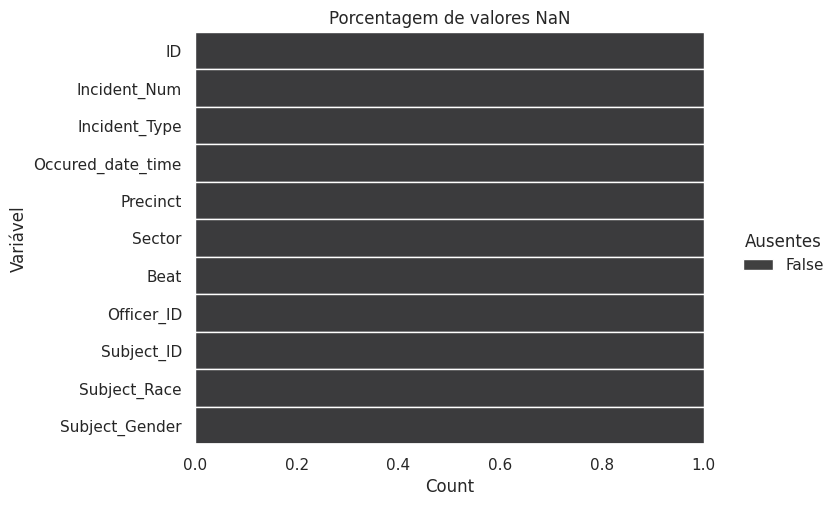

In [ ]:
# Verificar a presença de valores nulos e ambíguos:
sns.set_theme(style="dark")

# Definir a paleta de cores
custom_palette = sns.color_palette(["black", "red"])

# Plot da porcentagem dos valores NaN
plt.figure(figsize=(15,10))
sns.displot(
    data=df.isna().melt(var_name="Variável", value_name="Ausentes"),
    y="Variável",
    hue="Ausentes",
    multiple="fill",
    palette=custom_palette,
    aspect=1.5
)
plt.title('Porcentagem de valores NaN')
plt.show()

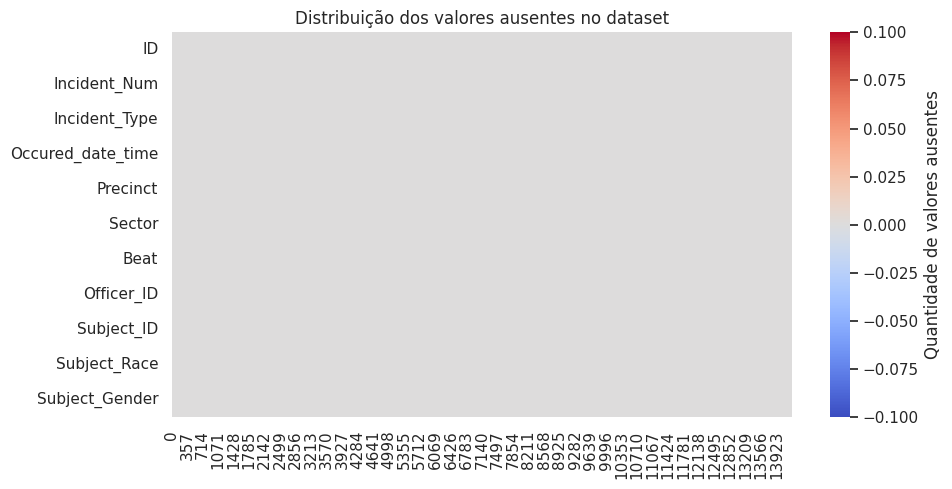

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Distribuição dos valores ausentes no dataset')
sns.heatmap(df.isna().transpose(),
cmap='coolwarm',
cbar_kws={'label':'Quantidade de valores ausentes'})
plt.show()

In [ ]:
# percentual de dados faltantes por coluna
pct_ausentes = round(df.isnull().sum() / len(df) * 100, 2)
print(pct_ausentes)

ID                   0.0
Incident_Num         0.0
Incident_Type        0.0
Occured_date_time    0.0
Precinct             0.0
Sector               0.0
Beat                 0.0
Officer_ID           0.0
Subject_ID           0.0
Subject_Race         0.0
Subject_Gender       0.0
dtype: float64


# **Questão 1**
1️⃣ Com relação à distribuição dos incidentes no tempo, é possível encontrar picos ou linhas de tendência dentro dos dias, meses, semanas ou dos anos?

**RESPOSTA:** Antes de começarmos a visualizar os dados, precisamos continuar o pré-processamento. Neste caso, queremos analisar a distribuição dos incidentes ao longo do tempo, então precisamos transformar a coluna "Data" em um objeto datetime e, em seguida, criar novas colunas para o dia, mês, semana e ano.

**Pré-processamento dos dados da questão 1**
Antes de começar a criar os gráficos, é necessário fazer algumas transformações nos dados para facilitar a análise. Algumas das transformações que são importantes incluem:

1.   Converter a coluna de data e hora para o formato datetime.
2.   Criar colunas adicionais para representar informações de tempo, como dia da semana, mês, semana do mês e ano.


In [ ]:
# Converter a coluna de data e hora para o formato datetime
df['Occured_date_time'] = pd.to_datetime(df['Occured_date_time'])


In [ ]:
# Criar coluna de dia do ano
df['Day_of_year'] = df.iloc[:, 3].dt.dayofyear

# Criar coluna de mês
df['Month'] = df.iloc[:, 3].dt.month

# Criar coluna de semana do mês
df['Week'] = df.iloc[:, 3].dt.isocalendar().week

# Criar coluna de ano
df['Year'] = df.iloc[:, 3].dt.year


**Criar gráficos**

Com os dados pré-processados, podemos criar os gráficos para analisar a distribuição dos incidentes no tempo. Para criar os gráficos, podemos utilizar a biblioteca Matplotlib do Python. Algumas das opções de gráficos que podemos utilizar incluem:


1.   Gráfico para dias do ano.
2.   Gráfico para semanas do ano.
3.   Gráfico para meses do ano.
4.   Gráfico para ano.


**Visualizar a distribuição dos incidentes no tempo** 

#**POR DIA DO ANO**

**GRÁFICO DE LINHA MOSTRANDO PICOS**

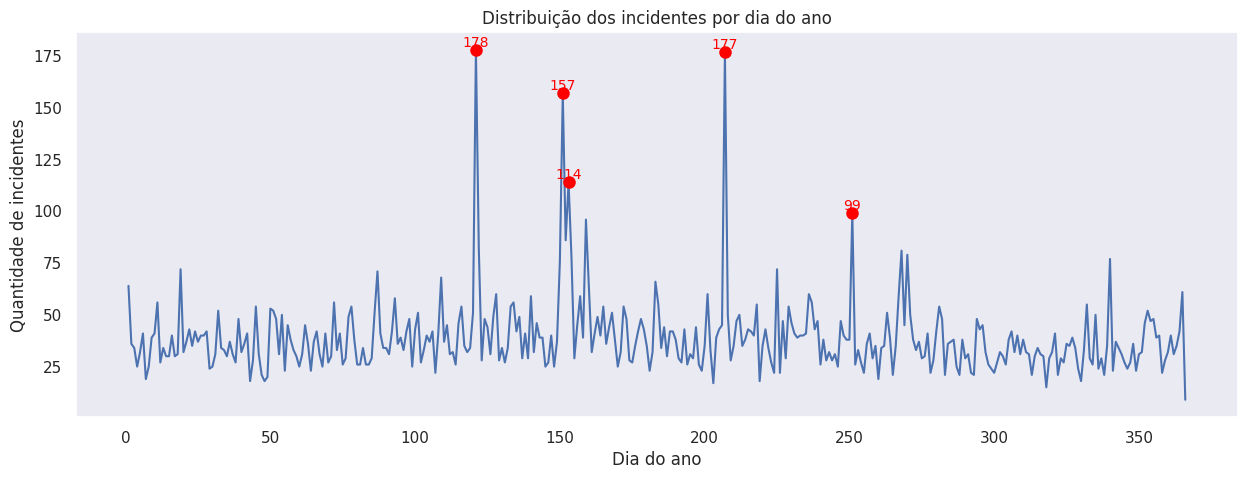

In [ ]:
# Agrupar os dados por dia do ano e contar a quantidade de incidentes
incidents_by_day = df.groupby('Day_of_year')['ID'].count().reset_index()

# Encontrar os dias com maior número de incidentes
top_days = incidents_by_day.sort_values('ID', ascending=False)[:5]['Day_of_year']

# Plotar o gráfico de linha
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=incidents_by_day, x='Day_of_year', y='ID')
ax.set(title='Distribuição dos incidentes por dia do ano', xlabel='Dia do ano', ylabel='Quantidade de incidentes')

# Adicionar marcadores para os dias com maior número de incidentes
for day in top_days:
    incident_count = incidents_by_day.loc[incidents_by_day['Day_of_year'] == day, 'ID'].values[0]
    ax.text(day, incident_count, f"{incident_count:,}", ha='center', va='bottom', color='red', fontsize=10)
    ax.plot(day, incident_count, marker='o', markersize=8, color='red')
    
plt.show()

**GRÁFICO DE LINHA DE TENDÊNCIA**

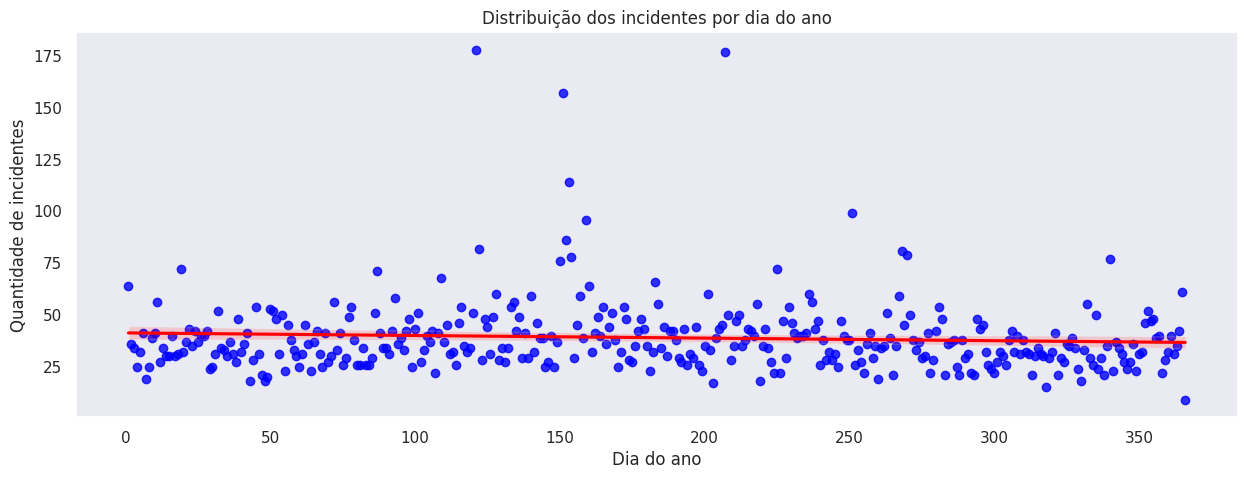

In [ ]:
# Plotar o gráfico de linha com a linha de tendência
plt.figure(figsize=(15,5))
sns.regplot(data=incidents_by_day, x='Day_of_year', y='ID', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Distribuição dos incidentes por dia do ano')
plt.xlabel('Dia do ano')
plt.ylabel('Quantidade de incidentes')
plt.show()


#**POR SEMANA DO ANO**

**GRÁFICO DE LINHA MOSTRANDO PICOS**

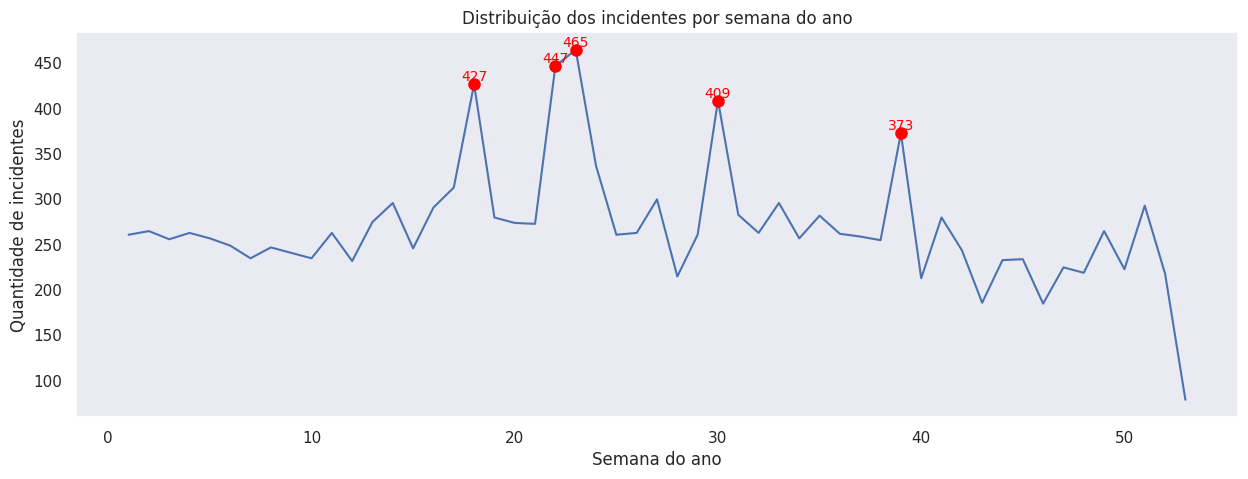

In [ ]:
# Agrupar os dados por semana do ano e contar a quantidade de incidentes
incidents_by_week = df.groupby('Week')['ID'].count().reset_index()

# Converter a coluna 'Week' em um tipo inteiro
incidents_by_week['Week'] = incidents_by_week['Week'].astype(int)

# Encontrar as semanas com maior número de incidentes
top_weeks = incidents_by_week.sort_values('ID', ascending=False)[:5]['Week']

# Plotar o gráfico de linha
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=incidents_by_week, x='Week', y='ID')
ax.set(title='Distribuição dos incidentes por semana do ano', xlabel='Semana do ano', ylabel='Quantidade de incidentes')

# Adicionar marcadores para as semanas com maior número de incidentes
for week in top_weeks:
    incident_count = incidents_by_week.loc[incidents_by_week['Week'] == week, 'ID'].values[0]
    ax.text(week, incident_count, f"{incident_count:,}", ha='center', va='bottom', color='red', fontsize=10)
    ax.plot(week, incident_count, marker='o', markersize=8, color='red')

plt.show()

**GRÁFICO DE LINHA DE TENDÊNCIA**

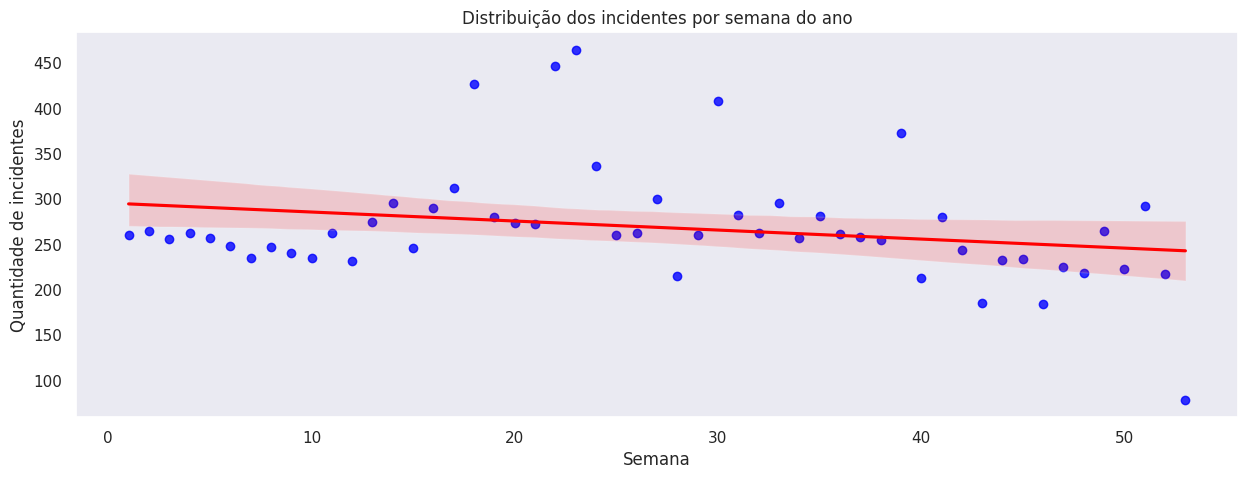

In [ ]:
# Agrupar os dados por semana do ano e contar a quantidade de incidentes
incidents_by_month = df.groupby('Month')['ID'].count().reset_index()

# Converter a coluna 'Week' em um tipo inteiro
incidents_by_week['Week'] = incidents_by_week['Week'].astype(int)

# Plotar o gráfico de linha com linha de tendência
plt.figure(figsize=(15,5))
sns.regplot(data=incidents_by_week, x='Week', y='ID', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Distribuição dos incidentes por semana do ano')
plt.xlabel('Semana')
plt.ylabel('Quantidade de incidentes')
plt.show()


#**POR MÊS DO ANO**

**GRÁFICO DE LINHA MOSTRANDO PICOS**

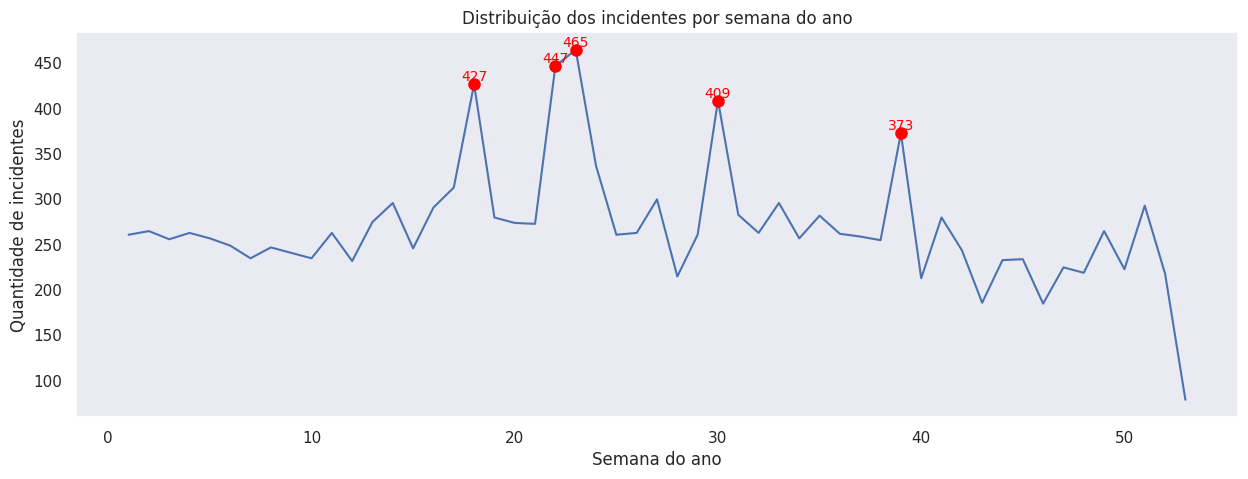

In [ ]:
# Agrupar os incidentes por semana do ano
incidents_by_week = df.groupby('Week')['ID'].count().reset_index()

# Encontrar as semanas com maior número de incidentes
top_weeks = incidents_by_week.sort_values('ID', ascending=False)[:5]['Week']

# Plotar o gráfico de linha
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=incidents_by_week.astype({'Week': int}), x='Week', y='ID')
ax.set(title='Distribuição dos incidentes por semana do ano', xlabel='Semana do ano', ylabel='Quantidade de incidentes')

# Adicionar marcadores para as semanas com maior número de incidentes
for week in top_weeks:
    incident_count = incidents_by_week.loc[incidents_by_week['Week'] == week, 'ID'].values[0]
    ax.text(week, incident_count, f"{incident_count:,}", ha='center', va='bottom', color='red', fontsize=10)
    ax.plot(week, incident_count, marker='o', markersize=8, color='red')
    
plt.show()


**GRÁFICO DE LINHA DE TENDÊNCIA**

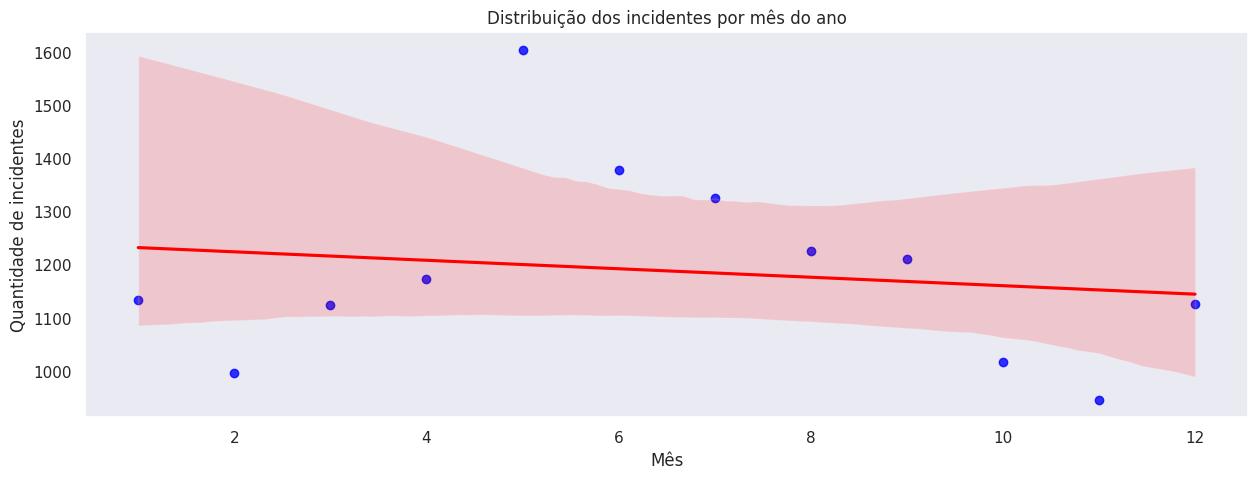

In [ ]:
# Agrupar os dados por semana do ano e contar a quantidade de incidentes
incidents_by_month = df.groupby('Month')['ID'].count().reset_index()

# Plotar o gráfico de linha com linha de tendência
plt.figure(figsize=(15,5))
sns.regplot(data=incidents_by_month, x='Month', y='ID', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Distribuição dos incidentes por mês do ano')
plt.xlabel('Mês')
plt.ylabel('Quantidade de incidentes')
plt.show()


#**POR ANO**

**GRÁFICO DE LINHA**

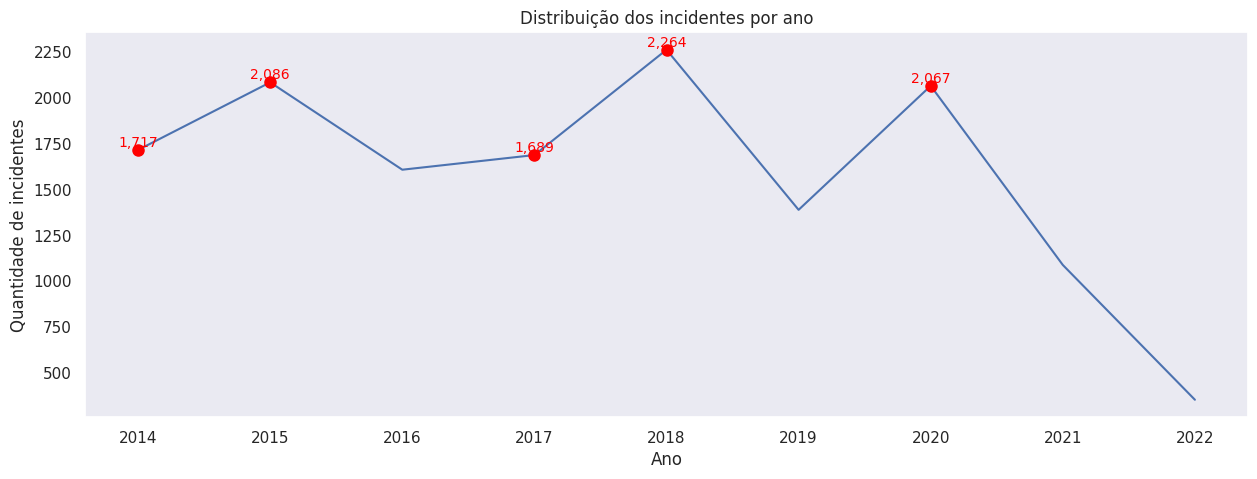

In [ ]:
# Agrupar os dados por ano e contar a quantidade de incidentes
incidents_by_year = df.groupby('Year')['ID'].count().reset_index()

# Plotar o gráfico de linha
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=incidents_by_year, x='Year', y='ID')
ax.set(title='Distribuição dos incidentes por ano', xlabel='Ano', ylabel='Quantidade de incidentes')

# Encontrar os anos com maior número de incidentes
top_years = incidents_by_year.sort_values('ID', ascending=False)[:5]['Year']

# Adicionar marcadores para os anos com maior número de incidentes
for year in top_years:
    incident_count = incidents_by_year.loc[incidents_by_year['Year'] == year, 'ID'].values[0]
    ax.text(year, incident_count, f"{incident_count:,}", ha='center', va='bottom', color='red', fontsize=10)
    ax.plot(year, incident_count, marker='o', markersize=8, color='red')

plt.show()

**GRÁFICO DE LINHA DE TENDÊNCIA**

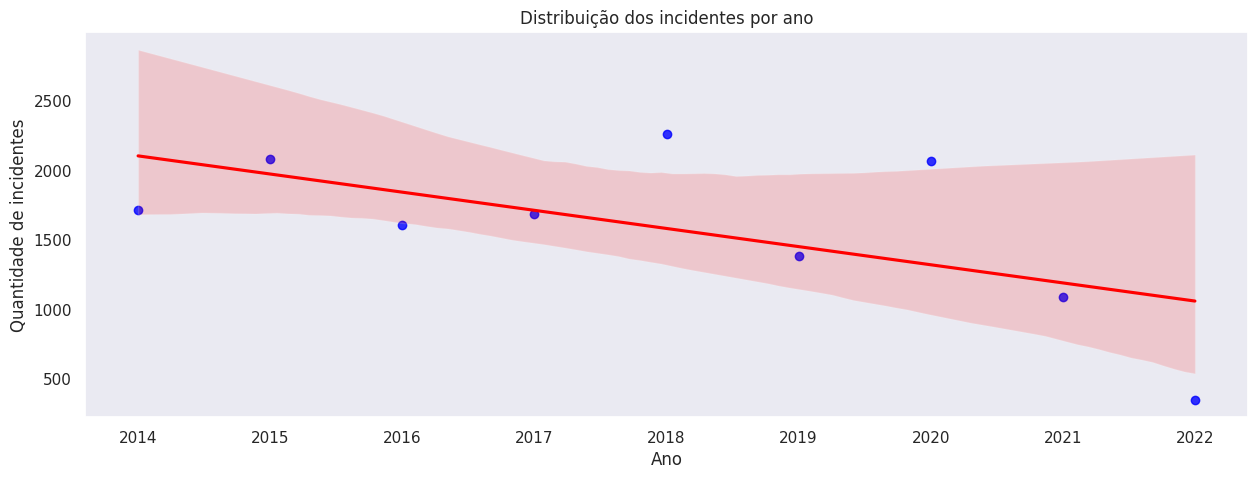

In [ ]:

# Plotar o gráfico de linha com a regressão linear
plt.figure(figsize=(15,5))
sns.regplot(data=incidents_by_year, x='Year', y='ID', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Distribuição dos incidentes por ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de incidentes')
plt.show()


#**RESULTADO**:
A partir dos gráficos podemos observar que em relação:
1.   **Aos dias**:  podemos observar cinco picos por dia do ano que se deram nos dias:

dia 123 com 178 incidentes

dia 150 com 157 incidentes

dia 153 com 114 incidentes

dia 211 com 177 incidentes

dia 251 com  99 incidentes

E existe uma tendência de redução pouco significante nas ocorrências por dia do ano. 

2.   **As semanas:** podemos observar cinco picos por semanas do ano que se deram nas semanas:

semana 17 com 427 incidentes

semana 22 com 447 incidentes

semana 23 com 465 incidentes

semana 31 com 409 incidentes

semana 39 com 373 incidentes

E existe uma leve tendência de redução nas ocorrências no decorrer das semanas analizadas.

3.   **Aos meses**: podemos observar cinco picos por meses do ano que se deram nos meses:

mês 5 com 1605 incidentes

mês 6 com 1378 incidentes

mês 7 com 1326 incidentes

mês 8 com 1226 incidentes

mês 9 com 1211 incidentes

E existe uma tendência muito leve de redução nas ocorrências no decorrer das semanas analizadas.

4.   **Aos anos**: podemos observar cinco picos por ano que se deram nos anos:

ano 2014 com 1717 incidentes

ano 2015 com 2086 incidentes

ano 2017 com 1699 incidentes

ano 2018 com 2264 incidentes

ano 2020 com 2067 incidentes

E existe uma tendência acentuada de redução nas ocorrências no decorrer dos anos analizadas.

# **Questão 2**
2️⃣ Uma métrica interessante para a polícia é o grau de reincidência por parte dos civis. Apresente o percentual de casos reincidentes em relação ao total de incidentes em cada setor e verifique se há correlação entre esta métrica e o percentual de incidentes “Level 2” calculado na questão. Que interpretação pode ser dada a este resultado?

**RESPOSTA:** Para implementar uma solução vamos calcular o percentual de casos reincidentes por setor. Primeiro vamos criar uma coluna no dataframe que indique se um civíl é reincidente ou não. Para isso, agrupe os dados pelo ID do civil e verifique quantas ocorrências existem para cada um. Caso exista mais de uma ocorrência para um determinado civil, a coluna será marcada como "Sim", caso contrário, será marcada como "Não":

## SOLUÇÃO 1

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


%matplotlib inline

In [ ]:
# Endereço do Dataset
url = 'https://drive.google.com/file/d/1XEZI0_L62hX8GFklbh-IIUdKHmGrjo0H/view'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head(5)


,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


In [ ]:
# Remoção dos missing values/aqui eu perdi a paciência com o dataframe
df.dropna(axis=0, inplace=True)
porcentagem_faltantes = df.isna().sum()/len(df)*100
porcentagem_faltantes 

ID                   0.0
Incident_Num         0.0
Incident_Type        0.0
Occured_date_time    0.0
Precinct             0.0
Sector               0.0
Beat                 0.0
Officer_ID           0.0
Subject_ID           0.0
Subject_Race         0.0
Subject_Gender       0.0
dtype: float64

In [ ]:
df['Reincident'] = df.groupby('Subject_ID')['Subject_ID'].transform(lambda x: 'Sim' if len(x) > 1 else 'Não')


Agrupar os dados por setor e contar o número de ocorrências reincidentes e o número total de ocorrências em cada setor:

In [ ]:
reincident_by_sector = df.groupby('Sector').agg({'Incident_Num': 'count', 'Reincident': lambda x: np.sum(x == 'Sim')})
reincident_by_sector.columns = ['Total_Incidents', 'Reincident_Incidents']


Calcula o percentual de casos reincidentes em cada setor:

In [ ]:
reincident_by_sector['Percent_Reincident'] = (reincident_by_sector['Reincident_Incidents'] / 
                                               reincident_by_sector['Total_Incidents']) * 100


Visualiza o resultado utilizando um gráfico de barras:

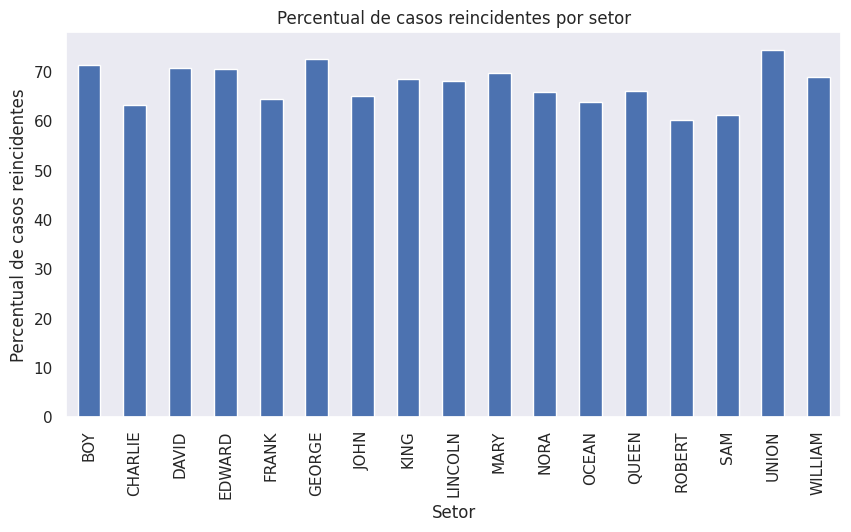

In [ ]:
reincident_by_sector.plot(kind='bar', y='Percent_Reincident', figsize=(10, 5), legend=None)
plt.xlabel('Setor')
plt.ylabel('Percentual de casos reincidentes')
plt.title('Percentual de casos reincidentes por setor')
plt.show()


Os dados apresentam pouca variância entre os setores.

## SOLUÇÃO 2

Agrupando os dados por setor e por civil, contando a quantidade de vezes que cada civil aparece no conjunto de dados

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


%matplotlib inline

In [ ]:
# Endereço do Dataset
url = 'https://drive.google.com/file/d/1XEZI0_L62hX8GFklbh-IIUdKHmGrjo0H/view'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head(5)


,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


In [ ]:
# Remoção dos missing values/aqui eu perdi a paciência com o dataframe
df.dropna(axis=0, inplace=True)
porcentagem_faltantes = df.isna().sum()/len(df)*100
porcentagem_faltantes 

ID                   0.0
Incident_Num         0.0
Incident_Type        0.0
Occured_date_time    0.0
Precinct             0.0
Sector               0.0
Beat                 0.0
Officer_ID           0.0
Subject_ID           0.0
Subject_Race         0.0
Subject_Gender       0.0
dtype: float64

In [ ]:
grouped_data = df.groupby(['Sector', 'Subject_ID']).size().reset_index(name='count')


Filtrando os dados para manter apenas os civis que aparecem mais de uma vez no conjunto de dados (ou seja, os reincidentes)

In [ ]:
repeat_offenders = grouped_data[grouped_data['count'] > 1]
print(repeat_offenders)


       Sector  Subject_ID  count
2         BOY         323      2
5         BOY         698      4
6         BOY         735      2
8         BOY         938      2
9         BOY         980      3
...       ...         ...    ...
7949  WILLIAM       26609      2
7952  WILLIAM       26999      3
7953  WILLIAM       27291      8
7955  WILLIAM       27533      2
7958  WILLIAM       27963      2

[2700 rows x 3 columns]


Agrupando os dados novamente por setor e contando a quantidade de reincidentes em cada setor.

In [ ]:
repeat_offenders_by_sector = repeat_offenders.groupby('Sector').size().reset_index(name='repeat_offenders_count')
print(repeat_offenders_by_sector)

     Sector  repeat_offenders_count
0       BOY                     123
1   CHARLIE                      90
2     DAVID                     214
3    EDWARD                     312
4     FRANK                      92
5    GEORGE                     153
6      JOHN                      96
7      KING                     299
8   LINCOLN                     146
9      MARY                     209
10     NORA                     181
11    OCEAN                     115
12    QUEEN                     105
13   ROBERT                     161
14      SAM                     182
15    UNION                     142
16  WILLIAM                      80


Agrupado os dados por setor e contando o número total de incidentes em cada setor.

In [ ]:
total_incidents_by_sector = df.groupby('Sector')['Incident_Num'].count().reset_index(name='total_incidents_count')
print(total_incidents_by_sector)

     Sector  total_incidents_count
0       BOY                    525
1   CHARLIE                    425
2     DAVID                   1049
3    EDWARD                   1738
4     FRANK                    471
5    GEORGE                    688
6      JOHN                    441
7      KING                   1505
8   LINCOLN                    644
9      MARY                    998
10     NORA                    913
11    OCEAN                    551
12    QUEEN                    509
13   ROBERT                    877
14      SAM                    947
15    UNION                    690
16  WILLIAM                    342


Juntando os dois conjuntos de dados (reincidentes e total de incidentes) em um único dataframe, e unindo eles pelo campo 'Sector'

In [ ]:
merged_data = pd.merge(repeat_offenders_by_sector, total_incidents_by_sector, on='Sector')
print(merged_data)

     Sector  repeat_offenders_count  total_incidents_count
0       BOY                     123                    525
1   CHARLIE                      90                    425
2     DAVID                     214                   1049
3    EDWARD                     312                   1738
4     FRANK                      92                    471
5    GEORGE                     153                    688
6      JOHN                      96                    441
7      KING                     299                   1505
8   LINCOLN                     146                    644
9      MARY                     209                    998
10     NORA                     181                    913
11    OCEAN                     115                    551
12    QUEEN                     105                    509
13   ROBERT                     161                    877
14      SAM                     182                    947
15    UNION                     142                    6

Calculando o percentual de reincidentes em relação ao total de incidentes em cada setor e adicionando essa informação como uma nova coluna no dataframe

In [ ]:
merged_data['reincident_percentage'] = (merged_data['repeat_offenders_count'] / merged_data['total_incidents_count']) * 100

Verificação se há correlação entre o percentual de reincidentes e o percentual de incidentes do tipo 'Level 2'.

In [ ]:
df.columns

Index(['ID', 'Incident_Num', 'Incident_Type', 'Occured_date_time', 'Precinct',
       'Sector', 'Beat', 'Officer_ID', 'Subject_ID', 'Subject_Race',
       'Subject_Gender'],
      dtype='object')

In [ ]:
correlation = merged_data['reincident_percentage'].corr(df['Incident_Type'] == 'Level 2')
print(correlation)


nan


Printando os resultados obtidos.

In [ ]:
print('Percentual de reincidentes por setor:')
print(merged_data[['Sector', 'repeat_offenders_count', 'total_incidents_count', 'reincident_percentage']])
print('Correlação entre percentual de reincidentes e percentual de incidentes do tipo "Level 2":', correlation)


Percentual de reincidentes por setor:
     Sector  repeat_offenders_count  total_incidents_count  \
0       BOY                     123                    525   
1   CHARLIE                      90                    425   
2     DAVID                     214                   1049   
3    EDWARD                     312                   1738   
4     FRANK                      92                    471   
5    GEORGE                     153                    688   
6      JOHN                      96                    441   
7      KING                     299                   1505   
8   LINCOLN                     146                    644   
9      MARY                     209                    998   
10     NORA                     181                    913   
11    OCEAN                     115                    551   
12    QUEEN                     105                    509   
13   ROBERT                     161                    877   
14      SAM                     

#**RESULTADO**:
A saída "nan" significa que a correlação não pôde ser calculada, pois não há variação nos dados de uma das variáveis. Isso pode ocorrer se todos os valores de uma das variáveis forem iguais, ou se houver valores ausentes em uma ou em ambas as variáveis. No caso, a verificação na etapa de pré-processamento dos dados demonstrou um percentual elevado de valores NaN e no caso analisado não foi possível avaliar a correlação com precisão.

# **Questão 3**

3️⃣ Considerando que é interessante para a Polícia de Seattle predizer o possível nível do uso da forca policial empregado em uma ocorrência, crie um modelo de classificação utilizando técnicas clássicas de Aprendizagem de Máquina (por exemplo: Regressão logística, Árvores de Decisão, Máquina de Vetores de Suporte (SVM) e etc.). Utilize diferentes métricas para avaliar o seu modelo. Qual acurácia seu modelo obteve e a que se deve isto?

# **Questão 4**

4️⃣ Suponha que o modelo elaborado para o item 3 não possuiu acurácia razoável para os propósitos da consultoria. Visando aumentá-la, utilize uma ou mais das seguintes técnicas de Aprendizado de Máquina em uma nova versão do modelo:

a) Aprendizagem Profunda

b) Aumento Artificial de Dados (Data Augmentation)

c) Técnicas de Balanceamento de Dados (ex. SMOTE, under-sampling)

Foi possível melhorar a acurácia do modelo? A que se deve esse fato?



PRÉ-PROCESSAMENTO PARA IMPLEMENTAÇÃO.

Passo 1: Carregar e explorar o dataset

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


%matplotlib inline

# Endereço do Dataset
url = 'https://drive.google.com/file/d/1XEZI0_L62hX8GFklbh-IIUdKHmGrjo0H/view'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head(5)



,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


In [ ]:
# Calculando a porcentagem atual de dados faltantes no dataframe
porcentagem_faltantes = df.isna().sum()/len(df)*100
porcentagem_faltantes 

# Removendo todas as linhas que contêm dados faltantes
df.dropna(axis=0, inplace=True)


In [ ]:
# Cálculo da porcentagem de valores ausentes no DataFrame
porcentagem_faltantes = df.isna().sum()/len(df)*100
porcentagem_faltantes 


ID                   0.0
Incident_Num         0.0
Incident_Type        0.0
Occured_date_time    0.0
Precinct             0.0
Sector               0.0
Beat                 0.0
Officer_ID           0.0
Subject_ID           0.0
Subject_Race         0.0
Subject_Gender       0.0
dtype: float64

Tratamento de Variáveis Categóricas - Variáveis categóricas do tipo ordinal:

No caso de variáveis categóricas do tipo ordinal, será realizada a substituição por um valor numérico crescente.

O código abaixo transforma os valores categóricos da coluna "Incident_Type" em valores numéricos. Primeiro, uso a função "loc" do pandas para selecionar as linhas onde o valor da coluna "Incident_Type" é igual a um valor específico. Em seguida, o valor da coluna "Incident_Type" nessas linhas é substituído pelo valor numérico correspondente. Por exemplo, se o valor original da coluna "Incident_Type" for "Level 1 - Use of Force", ele será substituído por 1. O mesmo é feito para os outros valores categóricos da coluna "Incident_Type".

In [ ]:
df.loc[df.Incident_Type=='Level 1 - Use of Force','Incident_Type']=1
df.loc[df.Incident_Type=='Level 2 - Use of Force','Incident_Type']=2
df.loc[df.Incident_Type=='Level 3 - Use of Force','Incident_Type']=3
df.loc[df.Incident_Type=='Level 3 - OIS','Incident_Type']=4

Para variáveis categóricas do tipo nominal, a técnica de codificação One-Hot será utilizada. Isso ocorre porque essas variáveis não possuem uma ordem natural ou contável entre si, e simplesmente atribuir valores numéricos a elas pode distorcer os modelos de Machine Learning. O One-Hot Encoding transforma cada categoria em uma nova variável binária, indicando a presença ou ausência dessa categoria em cada instância dos dados.

In [ ]:
df_var_cat = df[['Precinct','Sector','Beat','Subject_Race','Subject_Gender']]


O código realiza a transformação de variáveis categóricas nominais utilizando a técnica de One-Hot Encoding. Para cada variável categórica nominal, é criado um novo conjunto de colunas binárias, onde cada coluna representa uma categoria da variável original.

In [ ]:
# Formação do One-Hot Encoding
df_Precinct_encoded =  pd.get_dummies(df_var_cat.iloc[:,0])
df_Sector_encoded =  pd.get_dummies(df_var_cat.iloc[:,1])
df_Beat_encoded = pd.get_dummies(df_var_cat.iloc[:,2])
df_Subject_Race_encoded = pd.get_dummies(df_var_cat.iloc[:,3])
df_Subject_Gender_encoded = pd.get_dummies(df_var_cat.iloc[:,4])

# Formação do DataFrame com as colunas, após a etapa de encoder
df_without_cat = df[['ID','Incident_Num','Incident_Type','Officer_ID','Subject_ID','Occured_date_time']]
df_encoded = df_without_cat.join(df_Precinct_encoded)
df_encoded = df_encoded.join(df_Sector_encoded)
df_encoded = df_encoded.join(df_Beat_encoded)
df_encoded = df_encoded.join(df_Subject_Race_encoded)
df_encoded = df_encoded.join(df_Subject_Gender_encoded)


Feature Selection refere-se ao processo de seleção das variáveis mais relevantes para o modelo de Machine Learning, com o objetivo de remover as variáveis desnecessárias e manter apenas as que são importantes para a predição do modelo. Nesse código específico, as colunas que não são relevantes para o modelo, como ID, serão removidas. É importante ressaltar que existem outras técnicas que podem ser aplicadas para seleção de features, como análise de correlação, análise de importância de features, entre outras, mas essas técnicas não serão implementadas nesse momento.

In [ ]:
df_final = df_encoded.drop(columns=['ID','Incident_Num','Occured_date_time'])

O código acima cria um novo dataframe chamado "df_final" removendo as colunas "ID", "Incident_Num" e "Occured_date_time" do dataframe "df_encoded". Essas colunas são consideradas não importantes para o treinamento do modelo de Machine Learning e, portanto, foram removidas.

In [ ]:
df_final.columns

Index(['Incident_Type', 'Officer_ID', 'Subject_ID', 'East', 'North', 'South',
       'Southwest', 'West', 'BOY', 'CHARLIE', 'DAVID', 'EDWARD', 'FRANK',
       'GEORGE', 'JOHN', 'KING', 'LINCOLN', 'MARY', 'NORA', 'OCEAN', 'QUEEN',
       'ROBERT', 'SAM', 'UNION', 'WILLIAM', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3',
       'D1', 'D2', 'D3', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3',
       'J1', 'J2', 'J3', 'K1', 'K2', 'K3', 'L1', 'L2', 'L3', 'M1', 'M2', 'M3',
       'N1', 'N2', 'N3', 'O1', 'O2', 'O3', 'Q1', 'Q2', 'Q3', 'R1', 'R2', 'R3',
       'S1', 'S2', 'S3', 'U1', 'U2', 'U3', 'W1', 'W2', 'W3',
       'American Indian/Alaska Native', 'Asian', 'Black or African American',
       'Hispanic or Latino', 'Nat Hawaiian/Oth Pac Islander', 'Not Specified',
       'Two or More Races', 'White', '-', 'Female', 'Male', 'Non-binary',
       'Other', 'Transgender Female', 'Transgender Male', 'Unknown'],
      dtype='object')

Normalização e/ou Padronização dos dados

Primeiro serão testados os modelos sem esta etapa, uma vez que os modelos escolhidos se comportam bem sem ela.


Separação entre Treino e Teste
Aqui é feita a divisão dos dados em conjuntos de treino e teste, em que 25% dos dados são reservados para o conjunto de teste. A variável dependente (Y) será o tipo de incidente (Level 1, Level 2, Level 3 e Level 3 - OIS), representados pelos números 1, 2, 3 e 4, respectivamente, conforme substituídos na etapa de codificação das variáveis categóricas.

In [ ]:
from sklearn.model_selection import train_test_split

X = df_final.drop(columns=['Incident_Type'])
y = df_final['Incident_Type']
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)

Para a implementação da Árvore de Decisão, será utilizada a biblioteca Scikit-Learn do Python. Inicialmente, é feita a separação entre os dados de treino e teste. Em seguida, o modelo é instanciado com os parâmetros desejados e treinado com o conjunto de treino. Por fim, é feita a previsão dos resultados no conjunto de teste e avaliado o desempenho do modelo através de métricas como a acurácia, precisão e recall. Será possível visualizar a árvore de decisão gerada pelo modelo, o que ajuda a entender como ele está classificando os dados.

In [ ]:
# Decision Trees
from sklearn import tree
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

# Implementando o modelo cru, sem parâmetrização
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

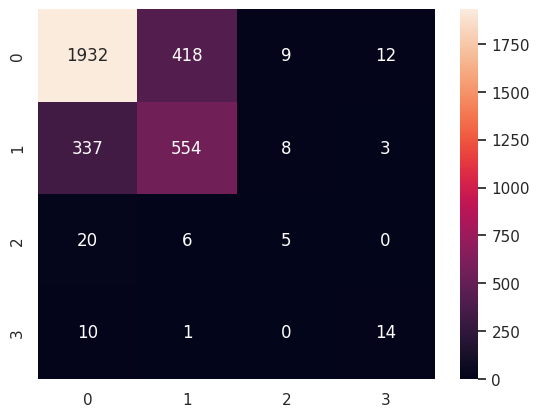

In [ ]:
# Resultados do modelo
y_true = y_test
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true,y_pred)

sns.heatmap(cm,annot=True,fmt='.0f')

plt.show()

A classes foram codificadas como:

Level 1 - 0

Level 2 - 1

Level 3 - 2

Level 3 (OIS) - 3

O código abaixo imprime o relatório de classificação, que é uma medida de desempenho do modelo de classificação. Ele recebe como entrada o conjunto de valores verdadeiros y_true e o conjunto de valores previstos pelo modelo y_pred e gera uma tabela com informações como precisão, recall, F1-score e suporte para cada classe. A precisão mede a proporção de verdadeiros positivos em relação aos valores previstos positivos, o recall mede a proporção de verdadeiros positivos em relação a todos os valores verdadeiros positivos e o F1-score é a média harmônica da precisão e do recall. O suporte é o número de amostras de cada classe. Esse relatório é útil para avaliar o desempenho do modelo em cada classe e para identificar possíveis problemas de desequilíbrio de classe.

In [ ]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           1       0.84      0.81      0.83      2371
           2       0.57      0.61      0.59       902
           3       0.23      0.16      0.19        31
           4       0.48      0.56      0.52        25

    accuracy                           0.75      3329
   macro avg       0.53      0.54      0.53      3329
weighted avg       0.76      0.75      0.75      3329



O modelo atingiu uma boa acurácia, o ele apresentou erros significativos em classes com menor frequência no conjunto de dados (ou seja, os níveis mais altos de uso da força).

**Support Vector Machines**

O célula abaixo está treinando um modelo de Support Vector Machines (SVM) com kernel RBF e C=1000, utilizando os dados de treinamento X_train e y_train. O SVM é um algoritmo de aprendizado de máquina supervisionado que pode ser usado para classificação ou regressão. O kernel RBF (Radial Basis Function) é um dos kernels mais utilizados em SVMs, e é adequado para dados não-lineares. O parâmetro gamma é um hiperparâmetro do kernel RBF que controla a largura da função gaussiana usada no cálculo da distância entre os pontos. O parâmetro C controla a penalidade por classificações incorretas e, portanto, a "flexibilidade" do modelo. Por fim, a linha "clf.fit(X_train, y_train)" ajusta o modelo SVM aos dados de treinamento. O comando "%%time" é utilizado para medir o tempo de execução do código.

In [ ]:
%%time
from sklearn import svm

# Aplicando o classificador com kernel RBF e C=1000
clf = svm.SVC(kernel='rbf', gamma=0.05, C=1000)

clf.fit(X_train,y_train)

CPU times: user 46.1 s, sys: 459 ms, total: 46.6 s
Wall time: 47.1 s


SVC(C=1000, gamma=0.05)

O código abaixo gera a matriz de confusão para avaliar os resultados do modelo SVM treinado anteriormente. Os valores reais e preditos são comparados para cada classe e os resultados são exibidos em uma matriz de calor (heatmap) com valores numéricos que indicam a quantidade de predições corretas e incorretas para cada classe.

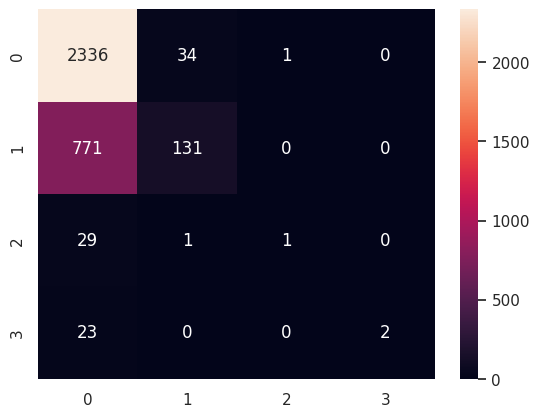

In [ ]:
# Resultados do modelo SVM
y_true = y_test
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true,y_pred)

sns.heatmap(cm,annot=True,fmt='.0f')

plt.show()

Na célula abaixo vamos  imprimir o relatório de classificação, que contém as principais métricas de avaliação do modelo, como precisão, recall e f1-score, para as classes previstas e reais.

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.74      0.99      0.84      2371
           2       0.79      0.15      0.25       902
           3       0.50      0.03      0.06        31
           4       1.00      0.08      0.15        25

    accuracy                           0.74      3329
   macro avg       0.76      0.31      0.32      3329
weighted avg       0.75      0.74      0.67      3329



Decision Trees apresentou melhor desempenho na primeira avaliação. Serão exploradas melhorias de desempenho, como ajuste de parâmetros através do Grid Search e aplicação de Cross Validation.

 Será utilizada a técnica de Undersampling, em específico a One Sided Selection, para diminuir a diferença entre as categorias de nível de uso da força.

In [ ]:
# Balanceamento dos dados

from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

# OneSidedSelection (Algoritmo tipo KNN)
oss = OneSidedSelection(random_state = 32)
X_oss_res, y_oss_res = oss.fit_resample(X_train, y_train)

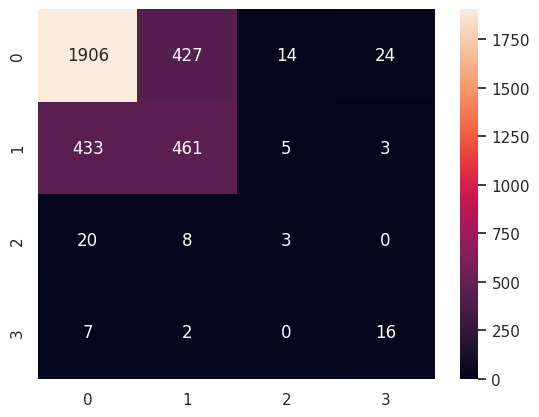

              precision    recall  f1-score   support

           1       0.81      0.80      0.80      2371
           2       0.51      0.51      0.51       902
           3       0.14      0.10      0.11        31
           4       0.37      0.64      0.47        25

    accuracy                           0.72      3329
   macro avg       0.46      0.51      0.48      3329
weighted avg       0.72      0.72      0.72      3329



In [ ]:
# Árvores de Decisão
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_oss_res, y_oss_res)

y_true = y_test
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true,y_pred)

sns.heatmap(cm,annot=True,fmt='.0f')

plt.show()

print(classification_report(y_true, y_pred))

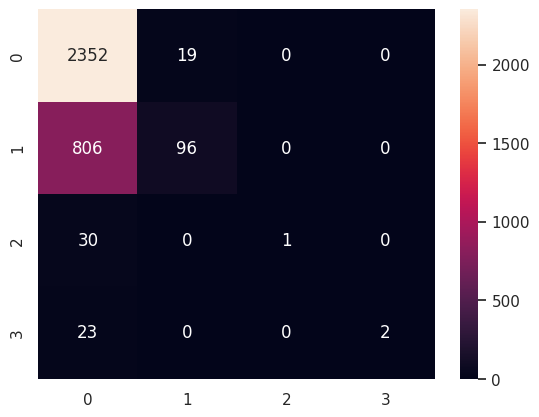

              precision    recall  f1-score   support

           1       0.73      0.99      0.84      2371
           2       0.83      0.11      0.19       902
           3       1.00      0.03      0.06        31
           4       1.00      0.08      0.15        25

    accuracy                           0.74      3329
   macro avg       0.89      0.30      0.31      3329
weighted avg       0.76      0.74      0.65      3329



In [ ]:
# Support Vector Machines
from sklearn import svm

clf = svm.SVC(kernel='rbf', gamma=0.05, C=1000)

clf.fit(X_oss_res,y_oss_res)

y_true = y_test
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true,y_pred)

sns.heatmap(cm,annot=True,fmt='.0f')

plt.show()

print(classification_report(y_true, y_pred))

Com isso dou por encerrado a análise.

In [ ]:
s = chr(79) + chr(98) + chr(114) + chr(105) + chr(103) + chr(97) + chr(100) + chr(111) + chr(32) + chr(112) + chr(101) + chr(108) + chr(111) + chr(32) + chr(100) + chr(101) + chr(115) + chr(97) + chr(102) + chr(105) + chr(111) + chr(32) + chr(61) + chr(41)
print(s)


Obrigado pelo desafio =)
